<a href="https://colab.research.google.com/github/Bharath2/cube/blob/master/PyDrake_Examples.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **PyDrake Setup**

In [ ]:
import importlib
import sys
from urllib.request import urlretrieve

# Install drake (and underactuated).
if 'google.colab' in sys.modules and importlib.util.find_spec('underactuated') is None:
    urlretrieve(f"http://underactuated.csail.mit.edu/scripts/setup/setup_underactuated_colab.py", "setup_underactuated_colab.py")
    from setup_underactuated_colab import setup_underactuated
    setup_underactuated(underactuated_sha='560c2adace05eb20ebd78377582015d5b2d3859a', drake_version='0.27.0', drake_build='release')


Cloning into '/opt/underactuated'...

HEAD is now at 560c2ad update mac requirements (removes torchvision)

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchvision 0.10.0+cu102 requires torch==1.9.0, but you have torch 1.8.1 which is incompatible.
torchtext 0.10.0 requires torch==1.9.0, but you have torch 1.8.1 which is incompatible.






### Start a Meshcat server instance for visualisation

In [ ]:
from meshcat.servers.zmqserver import start_zmq_server_as_subprocess

server_args = ['--ngrok_http_tunnel'] if 'google.colab' in sys.modules else []
reset_meshcat_server = lambda: start_zmq_server_as_subprocess(server_args = server_args)

proc, zmq_url, web_url =  reset_meshcat_server()

# Import Modules

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files
from IPython.display import HTML

from pydrake.all import (
    MultibodyPlant, SceneGraph, AddMultibodyPlantSceneGraph, DiagramBuilder, Simulator, Parser,
    RigidTransform, RotationMatrix, RollPitchYaw, Quaternion, PidController, LogOutput, GenerateHtml
)

from pydrake.examples.pendulum import PendulumPlant
from pydrake.systems.meshcat_visualizer import ConnectMeshcatVisualizer, MeshcatContactVisualizer

In [ ]:
ShowDiagram = lambda diagram: HTML('<script src="https://unpkg.com/gojs/release/go.js"></script>' + GenerateHtml(diagram))

### **Upload and unzip urdf**

In [ ]:
files.upload()

Saving robots.zip to robots.zip


{'robots.zip': b'PK\x03\x04\x14\x00\x00\x00\x00\x00\xcfc\x07S\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x07\x00 \x00robots/UT\r\x00\x07\x8f/\x0ea\xbd/\x0ea\x8f/\x0eaux\x0b\x00\x01\x04\xe8\x03\x00\x00\x04\xe8\x03\x00\x00PK\x03\x04\x14\x00\x08\x00\x08\x00\x19Y\xc1R\x00\x00\x00\x00\x00\x00\x00\x00\x04\x18\x00\x00\x10\x00 \x00robots/.DS_StoreUT\r\x00\x07\xea\xc7\xb5`\xc4/\x0ea\xb7A\taux\x0b\x00\x01\x04\xe8\x03\x00\x00\x04\xe8\x03\x00\x00\xed\x97MN\xc2@\x14\x80\xdf@\xc5\x01c\xec\xc2D\x96\xdd\xb8#\xa6\x80!\xb20\xa9\x15\x17\xecL0\xba@\x03\xadEiR:\x84\x16\x89bM\xaf\xa1\x97\xf0\x1c\x9e\xc0\xe3h\x7f\x9eH*,\x8c\x0bP\xe7K^\xbei\xfa\xa6\xed\xbc\xa63\x1d\x00 \xea\xd0(\x02\x88\x00@!\xb6\x90\x83\x99P\x8c/\xa4\xd0\x99 Ht\x8d\x0e8u\x8b]\xea\x16\xd3g_\x8b\xc3\xe1,\x11\x99(z\xe1\x97\x0b\xdd\xc4\xf7\x1bN\n\x07A\xec\xbcE`\xfeT\xae>r\xfa\x98\xfb\xa2\xf7-\xd3qe\xf9\x95\xa4\xd2\xc2Jf\x95\xd2\x1c\xcd\xad\xe7.\x1a]6j\xb8\x9a;tTm\xd0\x0c\x8f\x8e5\xb7\xabc\xfb\x841k\xd2\xd6\xf4S\xb33j\x89\x9b\x87\xccv5\xd3\x

In [ ]:
!unzip -a 'robots.zip'

Archive:  robots.zip
   creating: robots/
  inflating: robots/.DS_Store        [binary]
   creating: robots/urdf/
  inflating: robots/urdf/box.urdf    [binary]
  inflating: robots/urdf/cartpole.urdf  [binary]
  inflating: robots/urdf/biped.urdf  [binary]
   creating: robots/meshes/
  inflating: robots/meshes/.DS_Store  [binary]
   creating: robots/meshes/leg/
  inflating: robots/meshes/leg/.DS_Store  [binary]
  inflating: robots/meshes/leg/upperleg.dae  [binary]
  inflating: robots/meshes/leg/lowerleg.dae  [binary]
  inflating: robots/meshes/leg/hipassembly.obj  [binary]
  inflating: robots/meshes/leg/lowerleg.obj  [binary]
  inflating: robots/meshes/leg/hipassembly.dae  [binary]
  inflating: robots/meshes/leg/upperleg.obj  [binary]


# **PyDrake Intro**

### **Combinations of Systems: Diagram and DiagramBuilder**

The real modeling power of Drake comes from combining many smaller systems together into more complex systems.  The concept is very simple: we use the `DiagramBuilder` class to `AddSystem()`s and to `Connect()` input ports to output ports or to expose them as inputs/output of the diagram.  Then we call `Build()` to generate the new `Diagram` instance, which is just another `System` in the framework, and can be simulated or analyzed using the entire suite of tools.


In [ ]:
builder = DiagramBuilder()

# Add the pendulum.
pendulum = builder.AddSystem(PendulumPlant())
pendulum.set_name("pendulum")

controller = builder.AddSystem(PidController(kp=[20.], ki=[5.], kd=[10.]))
controller.set_name("controller")

# Now "wire up" the controller to the plant.
builder.Connect(pendulum.get_state_output_port(), controller.get_input_port_estimated_state())
builder.Connect(controller.get_output_port_control(), pendulum.get_input_port())

# Make the desired_state input of the controller an input to the diagram.
builder.ExportInput(controller.get_input_port_desired_state(), "DesiredState")

# Log the state of the pendulum.
logger = LogOutput(pendulum.get_state_output_port(), builder)
logger.set_name("logger")

diagram = builder.Build()
diagram.set_name("Pendulum")

In [ ]:
ShowDiagram(diagram)

## **The System "Context"**

The Context is a core concept in the Drake systems framework: the Context captures all of the dynamic information that a System requires to implement its core methods: this includes the time, the state, any inputs, and any system parameters. The Context of a System is everything you need to know for simulation or control design, etc., and given a Context all methods called on a System should be completely deterministic/repeatable.

Note that a Context is not completely defined unless all of the input ports are connected (simulation and other method calls will fail if they are not). For input ports that are not directly tied to the output of another system, consider using the port's FixValue method.

In [ ]:
context = diagram.CreateDefaultContext()
pendulum_context = pendulum.GetMyMutableContextFromRoot(context)
controller_context = controller.GetMyMutableContextFromRoot(context)

In [ ]:
desired_state = [np.pi/2, 0.]
initial_state = [np.pi/2+0.1, 0.2]

#Set initial state of pendulum plant
pendulum_context.SetContinuousState(initial_state)

#Fix value of desired state input
diagram.GetInputPort("DesiredState").FixValue(context, desired_state)

#See what's in the context
print(pendulum_context)

::Pendulum::pendulum Context
-----------------------------
Time: 0
States:
  2 continuous states
    1.6708    0.2

Parameters:
  1 numeric parameter groups with
     4 parameters
          1  0.5  0.1 9.81




## **Simulation**

Once you have acquired a `System` object describing the dynamics of interest, the most basic thing that you can do is to simulate it.  This is accomplished with the `pydrake.framework.analysis.Simulator` class. This class provides access to a rich suite of numerical integration routines, with support for variable-step integration, stiff solvers, and event detection.

In order to view the data from a simulation after the simulation has run, you should add a `pydrake.framework.primitives.SignalLogger` system to your diagram.

Use the following code to simulate the continuous time system we defined above, and plot the results:

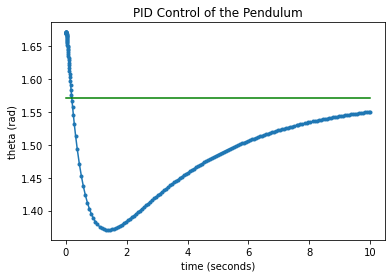

In [ ]:
# Set up a simulator to run this diagram.
simulator = Simulator(diagram, context)

logger.reset()
# Simulate for 10 seconds.
simulator.AdvanceTo(10);

# Plot the results.
t = logger.sample_times()
theta = logger.data()[0,:]

plt.figure()
plt.plot(t, theta,'.-')
plt.plot([t[0], t[-1]], [desired_state[0], desired_state[0]], 'g' )
plt.xlabel('time (seconds)')
plt.ylabel('theta (rad)')
plt.title('PID Control of the Pendulum');

# **Adding Multibody Plant**

### **Multibody Plant**
`MultibodyPlant` is a Drake system framework representation for the model of a physical system consisting of a collection of interconnected bodies. Model instances are frequently defined through **SDF** or **URDF** files and are automatically created when **SDF** files are parsed (by Parser). 

The state of a multibody system $x = [q, v]$ is given by its generalized positions vector $q$, of size $nq$, and by its generalized velocities vector $v$, of size $nv$. As a Drake System, MultibodyPlant implements the governing equations for a multibody dynamical system in the form $ẋ = f(t, x, u)$ with $t$ being time and $u$ the actuation forces.


### Some useful Api's of MultibodyPlant System:
num_positions(), num_velocities(), num_actuated_dofs(), GetPositionsAndVelocities(), GetPositions(), GetVelocities(), SetPositionsAndVelocities(), SetPositions(), SetVelocities(),  get_state_output_port(), get_actuation_input_port().

More on Multibody plant and other Api's of this system can be found here https://drake.mit.edu/pydrake/pydrake.multibody.plant.html#pydrake.multibody.plant.MultibodyPlant_


### **SceneGraph**

`SceneGraph` serves as the nexus for all geometry (and geometry-based operations) in a `Diagram`. `SceneGraph` provides the interface for registering the geometry, updating its position based on the current context, and performing geometric queries.

`MultibodyPlant` users can register geometry with a SceneGraph for essentially two purposes:
**a)** visualization and, **b)** contact modeling.

Once we have a `SceneGraph`, then there are a number of different visualizers and sensors that we can add to the system to actually render the scene.

More on SceneGraph here https://drake.mit.edu/pydrake/pydrake.geometry.html?highlight=scenegraph#pydrake.geometry.SceneGraph

# Cartpole example

Multibody plant can be added as follows

In [ ]:
builder = DiagramBuilder()

#Add MultibodyPlant system
plant = builder.AddSystem(MultibodyPlant(time_step = 0.0))
plant.set_name("cartpole")

#Add SceneGraph
scenegraph = builder.AddSystem(SceneGraph())
scenegraph.set_name("scenegraph")

#Parse urdf file
parse_ins = Parser(plant, scenegraph).AddModelFromFile("./robots/urdf/cartpole.urdf")
plant.Finalize()

#Connect geometry ports
builder.Connect(scenegraph.GetOutputPort("query"), plant.GetInputPort("geometry_query"))
builder.Connect(plant.GetOutputPort("geometry_pose"),scenegraph.get_input_port(0))

#build diagram
diagram = builder.Build()
diagram.set_name("diagram")

ShowDiagram(diagram)

But the efficient way is to use **"AddMultibodyPlantSceneGraph"** which adds the plant and scenegraph together and connects geometry ports

### **Visualizing the scene**

The best way to visualize the results of a physics engine is with a 2D or 3D visualizer. Drake supports a number of visualizers.  But because we're working in a jupyter notebook, and want to be able to run 3D graphics on any machine without any installation required, we'll use the [MeshCat](https://github.com/rdeits/meshcat) visualizer.

To use all three systems (`MultibodyPlant`, `SceneGraph`, and `MeshcatVisualizer`), we need to assemble them into a Diagram.  Often you would add each system and then connect the ports together, but for common cases like this, we have helper methods.


In [ ]:
builder = DiagramBuilder()

#Add multibody plant and SceneGraph
plant, scene_graph = AddMultibodyPlantSceneGraph(builder, time_step = 0.0)
plant.set_name("cartpole")

#Add model from urdf or sdf file
parse_ins  = Parser(plant, scene_graph).AddModelFromFile("./robots/urdf/cartpole.urdf")
plant.Finalize()

# Setup visualization
visualizer = ConnectMeshcatVisualizer(builder, scene_graph, zmq_url = zmq_url)
#uncomment to try planar view
#visualizer.set_planar_viewpoint(xmin=-2.5, xmax=2.5, ymin=-1.0, ymax=2.5)

#build diagram
diagram = builder.Build()
diagram.set_name("diagram")

Connecting to meshcat-server at zmq_url=tcp://127.0.0.1:6003...
You can open the visualizer by visiting the following URL:
http://c46c35169d22.ngrok.io/static/
Connected to meshcat-server.


In [ ]:
ShowDiagram(diagram)

### Add actuation input and simulate

In [ ]:
context = diagram.CreateDefaultContext()
plant_context = plant.GetMyMutableContextFromRoot(context)

#Set initial position aand angle
plant.SetPositions(plant_context, [0, np.pi+0.1])

#Fix actuation port with desired value
Force = [0] #try different values of force
plant.get_actuation_input_port().FixValue(plant_context, Force)

In [ ]:
simulator = Simulator(diagram, context)

#load and start recording
visualizer.load()
visualizer.start_recording()

#Advance to 5 seconds
simulator.AdvanceTo(5)

#stop recording and publish
visualizer.stop_recording()
visualizer.publish_recording()


**Visit the Meshcat url for visualisation.**

The recorded simulation can be replayed, paused or played in slowmotion from the animation tab on the side bar

#**Appling External Force**

Any number of forces can be applied externally on any number of bodies in a Multibody Plant. Let's try to push a Box on ground.


In [ ]:
proc, zmq_url, web_url = reset_meshcat_server()

In [ ]:
from pydrake.all import HalfSpace, CoulombFriction, SpatialForce, ExternallyAppliedSpatialForce

builder = DiagramBuilder()

#Add multibody plant and SceneGraph
plant, scene_graph = AddMultibodyPlantSceneGraph(builder, time_step = 0.0)
plant.set_name("box")

#Add model from urdf or sdf file
parse_ins  = Parser(plant, scene_graph).AddModelFromFile("./robots/urdf/box.urdf")

# #Add ground collision geometry with friction
plant.RegisterCollisionGeometry(plant.world_body(), RigidTransform(), HalfSpace(), 
                                      "GroundCollisionGeometry", CoulombFriction(0.3, 0.3));
plant.Finalize()

# Setup visualization
visualizer = ConnectMeshcatVisualizer(builder, scene_graph, zmq_url = zmq_url)

#build diagram
diagram = builder.Build()

Connecting to meshcat-server at zmq_url=tcp://127.0.0.1:6001...
You can open the visualizer by visiting the following URL:
http://5f9ef17fbb87.ngrok.io/static/
Connected to meshcat-server.


In [ ]:
#Create context
context = diagram.CreateDefaultContext()
plant_context = plant.GetMyMutableContextFromRoot(context)

#Get box body
box = plant.GetBodyByName("box")
plant.SetFreeBodyPose(plant_context, box, RigidTransform(RotationMatrix(), [0, 0, 0.52]))

#Define force object
force_object = ExternallyAppliedSpatialForce()
force_object.body_index = box.index()
force_object.F_Bq_W = SpatialForce(tau = np.zeros(3), f = np.array([50 , 0., 0]))

In [ ]:
simulator = Simulator(diagram, context)
simulator.set_target_realtime_rate(1.0)

simulator.AdvanceTo(5)

#Add force to plant
plant.get_applied_spatial_force_input_port().FixValue(plant_context, [force_object])

simulator.AdvanceTo(20)

**All Pydrake APi's can be found here** https://drake.mit.edu/pydrake/index.html


# **Biped Environment**

In [ ]:
proc, zmq_url, web_url = reset_meshcat_server()

### Pid controller for leg joints

In [ ]:
from pydrake.all import PidController, FirstOrderLowPassFilter

def biped_pid_control(plant):

  #pid gains
  kp = 200*np.ones(6)
  kp[-2:] = 250
  ki = 1*np.ones(6)
  kd = 50*np.ones(6)
  
  #state projection matrix, consider only leg joints from the whole state
  S = np.zeros((12, 25)) 
  S[:6, 7:13] = np.eye(6)
  S[6:, -6:] = np.eye(6)

  return PidController(kp = kp, ki = ki, kd = kd, state_projection = S,
                            output_projection = plant.MakeActuationMatrix()[6:,:].T)

### Biped Environment useful for Reinforcement Learning

In [ ]:
class BipedEnv():

  def __init__(self, init_state = None, visualize = False):

    #joint angle limits
    self.high = np.pi*np.array([ 0.25, 0.25, 0.5, 0.5, 0.1, 0.1])
    self.low  = np.pi*np.array([-0.25,-0.25, 0, 0, -0.75, -0.75])

    self.Setup(visualize)
    self.reset(init_state)


  def Setup(self, visualize = False):
    builder = DiagramBuilder()
    plant, scene_graph = AddMultibodyPlantSceneGraph(builder, time_step = 1e-5)
    parse_ins = Parser(plant, scene_graph).AddModelFromFile('./robots/urdf/biped.urdf')
    #Set Ground collision geometry
    plant.RegisterCollisionGeometry(plant.world_body(), RigidTransform(), HalfSpace(), 
                                      "GroundCollisionGeometry", CoulombFriction(0.6, 0.6));
    plant.Finalize()
    plant.set_penetration_allowance(1e-3)
    plant.set_name("Biped3d")

    #Add PidController
    controller = builder.AddSystem(biped_pid_control(plant))
    controller.set_name("PID_controller")
    builder.Connect(plant.get_state_output_port(), controller.get_input_port_estimated_state())
    builder.Connect(controller.get_output_port(), plant.get_actuation_input_port())
    builder.ExportInput(controller.get_input_port_desired_state(), "DesiredJointState")

    # Setup visualization
    self.visualizer = ConnectMeshcatVisualizer(builder, scene_graph, zmq_url = zmq_url) if visualize else None
      
    # Build diagram
    self.diagram = builder.Build()
    self.plant = plant
    self.scene_graph = scene_graph

    self.contactRes = plant.get_contact_results_output_port()
    self.InputPort = self.diagram.GetInputPort("DesiredJointState")

    self.W = plant.world_frame()
    self.base = plant.GetBodyByName("base")
    self.lf = plant.GetBodyByName("L_contact")
    self.rf = plant.GetBodyByName("R_contact")


  def reset(self, init_state = None):
    #reset time and simulator
    self.time = 0
    self.context = self.diagram.CreateDefaultContext()
    self.plant_context = self.plant.GetMyMutableContextFromRoot(self.context)
    self.simulator = Simulator(self.diagram, self.context)
    #set initial state
    self.set_state(init_state)
    return self.get_state
  

  def set_state(self, init_state = None):
    if init_state is None:
       q = [ 1, 0, 0, 0, 0, 0, 0.73, 0, 0, 0.8, 0.8, -1.6, -1.6]
       init_state = np.r_[q, [0]*12]
    else:
      quat = Quaternion(RollPitchYaw(init_state[:3])).wxyz()
      init_state = np.r_[quat, init_state[3:]]

    self.plant.SetPositionsAndVelocities(self.plant_context, init_state)
    self.InputPort.FixValue(self.context, np.r_[init_state[7:13],[0]*6])


  @property
  def get_state(self):
    #get current state from plant
    state = self.plant.GetPositionsAndVelocities(self.plant_context)
    quat, com, pos, omega, comdot, vel = np.split(state, np.cumsum([4, 3, 6, 3, 3]))
    rpy = RollPitchYaw(Quaternion(quat/np.linalg.norm(quat))).vector()

    #get foot contact states
    contact = [0, 0]
    cons = self.contactRes.Eval(self.plant_context)
    for i in range(cons.num_point_pair_contacts()):
      k = cons.point_pair_contact_info(i)
      if k.bodyB_index() == 0:
        if k.bodyA_index() == self.rf.index():
          contact[0] = 1
        elif k.bodyA_index() == self.lf.index():
          contact[1] = 1

    return np.r_[rpy, omega, com, comdot, pos, vel, contact]


  def step(self, pos, dt = 0.02):
    self.InputPort.FixValue(self.context, np.r_[pos,[0]*6])
    #Advance to next step
    self.simulator.AdvanceTo(self.time + dt)
    self.time += dt
    #return current state
    return self.get_state
  
  
  def start_recording(self, init_state = None):
    self.Setup(True)
    self.reset(init_state)
    self.visualizer.load()
    self.visualizer.start_recording()
  
  def stop_recording(self):
    self.visualizer.stop_recording()
    self.visualizer.publish_recording()

In [ ]:
env = BipedEnv()

In [ ]:
env.diagram.set_name('diagram')
ShowDiagram(env.diagram)

In [ ]:
def model(state):
  return np.array([0, 0, 0.8, 0.8, -1.6, -1.6])
  
env.start_recording()

# advance through env.step method 
for i in range(20):
    u = model(env.get_state)
    state = env.step(u)
 
env.simulator.AdvanceTo(env.time + 2)
env.stop_recording()

Connecting to meshcat-server at zmq_url=tcp://127.0.0.1:6004...
You can open the visualizer by visiting the following URL:
http://9433b6741b86.ngrok.io/static/
Connected to meshcat-server.
